In [68]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import math

In [9]:
today = datetime.today().strftime('%Y-%m-%d')
beginning = '2015-01-01'

In [101]:
tickers = {'Bonds':'HYG','S&P500':'SPY','BTC':'BTC-USD'}

In [102]:
for key in tickers.keys():
    tickers[key] = yf.download(tickers[key], start=beginning, end=today, progress=False)[["Adj Close"]]
data = pd.concat(list(tickers.values()), axis=1)
data.columns = tickers.keys()
data = data.dropna()

In [103]:
data

,Bonds,S&P500,BTC
Date,,,
2015-01-02,64.958183,182.746567,315.032013
2015-01-05,64.356430,179.446259,274.473999
2015-01-06,64.109962,177.756073,286.188995
2015-01-07,64.508713,179.971115,294.337006
2015-01-08,64.994415,183.164703,283.348999
...,...,...,...
2021-03-01,87.099998,389.579987,49631.242188
2021-03-02,86.970001,386.540009,48378.988281
2021-03-03,86.690002,381.420013,50538.242188


<AxesSubplot:xlabel='Date'>

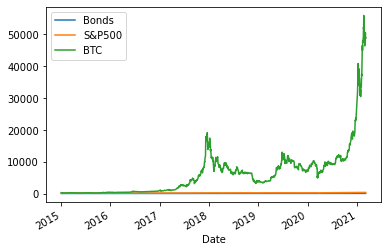

In [104]:
data.plot()

In [105]:
time_elapsed = (data.index[-1] - data.index[0]).days

In [106]:
time_elapsed

2254

In [110]:
#Current price / first record (e.g. price at beginning of 2009)
#provides us with the total growth %
number_of_years = time_elapsed / 365.0
number_of_trading_days = 252

cagr = {}
std_dev = {}

for element in data.columns:
    total_growth = (data[element][-1] / data[element][1])
    #Next, we want to annualize this percentage

    #we can raise the total growth to the inverse of the # of years
    #(e.g. ~1/10 at time of writing) to annualize our growth rate
    cagr[element] = total_growth ** (1/number_of_years) - 1

    #Now that we have the mean annual growth rate above,
    #we'll also need to calculate the standard deviation of the
    #daily price changes
    std_dev[element] = data[element].pct_change().std()

    #Next, because there are roughy ~252 trading days in a year,
    #we'll need to scale this by an annualization factor
    std_dev[element] = std_dev[element] * math.sqrt(number_of_trading_days)

    #From here, we have our two inputs needed to generate random
    #values in our simulation
    print (f"cagr (mean returns) for {element} : ", str(round(cagr[element],4)))
    print (f"std_dev (standard deviation of return : ) for {element}", str(round(std_dev[element],4)))

cagr (mean returns) for Bonds :  0.0493
std_dev (standard deviation of return : ) for Bonds 0.0882
cagr (mean returns) for S&P500 :  0.1309
std_dev (standard deviation of return : ) for S&P500 0.1827
cagr (mean returns) for BTC :  1.3148
std_dev (standard deviation of return : ) for BTC 0.7392


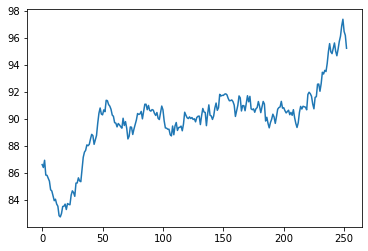

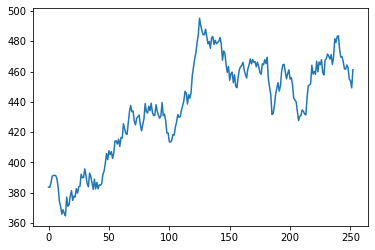

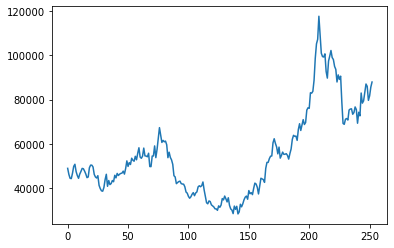

In [113]:
#Generate random values for 1 year's worth of trading (252 days),
#using numpy and assuming a normal distribution

daily_return_percentages = {}

for element in data.columns:
    daily_return_percentages[element] = np.random.normal(cagr[element]/number_of_trading_days, std_dev[element]/math.sqrt(number_of_trading_days),number_of_trading_days)+1

    #Now that we have created a random series of future
    #daily return %s, we can simply apply these forward-looking
    #to our last stock price in the window, effectively carrying forward
    #a price prediction for the next year
    #This distribution is known as a 'random walk'
    price_series = [data[element][-1]]

    for j in daily_return_percentages[element]:
        price_series.append(price_series[-1] * j)

    #Great, now we can plot of single 'random walk' of stock prices
    plt.plot(price_series)
    plt.show()

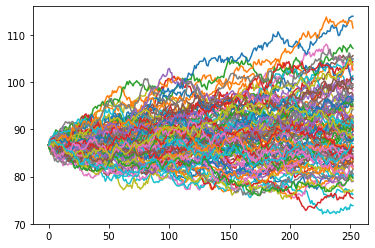

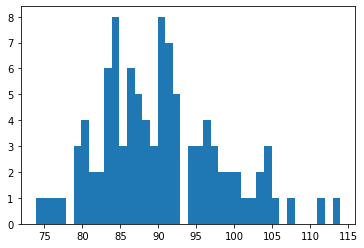

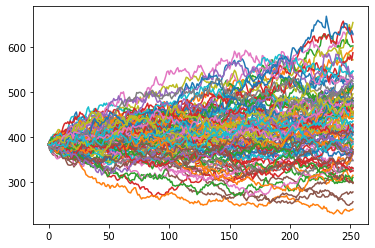

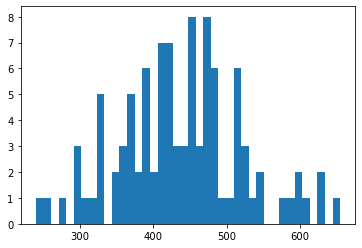

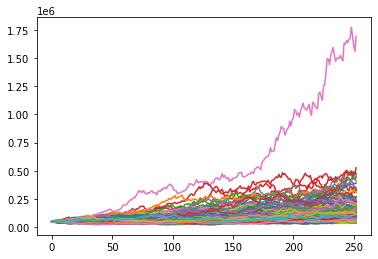

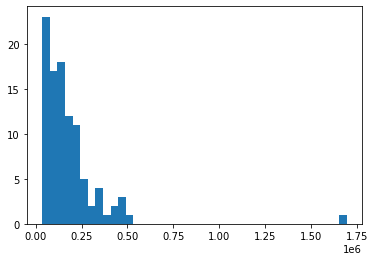

In [118]:
#Now that we've created a single random walk above,
#we can simulate this process over a large sample size to
#get a better sense of the true expected distribution
number_of_trials = 100

#set up an additional array to collect all possible
#closing prices in last day of window.
#We can toss this into a histogram
#to get a clearer sense of possible outcomes
closing_prices = {}

for element in data.columns:
    closing_prices[element] = []
    for i in range(number_of_trials):
        #calculate randomized return percentages following our normal distribution
        #and using the mean / std dev we calculated above
        daily_return_percentages[element] = np.random.normal(cagr[element]/number_of_trading_days, std_dev[element]/math.sqrt(number_of_trading_days),number_of_trading_days)+1
        price_series = [data[element][-1]]

        for j in daily_return_percentages[element]:
            #extrapolate price out for next year
            price_series.append(price_series[-1] * j)

        #append closing prices in last day of window for histogram
        closing_prices[element].append(price_series[-1])

        #plot all random walks
        plt.plot(price_series)



    plt.show()

    #plot histogram
    plt.hist(closing_prices[element],bins=40)

    plt.show()

In [119]:
#from here, we can check the mean of all ending prices
#allowing us to arrive at the most probable ending point

for element in data.columns:
    mean_end_price = round(np.mean(closing_prices[element]),2)
    print(f"Expected price for {element}: ", str(mean_end_price))

Expected price for Bonds:  90.31
Expected price for S&P500:  438.07
Expected price for BTC:  182930.29


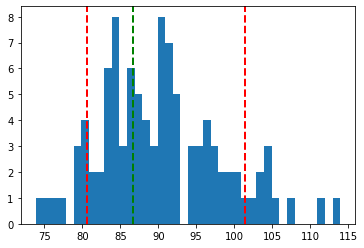

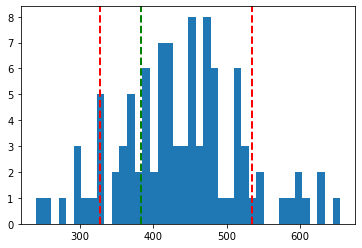

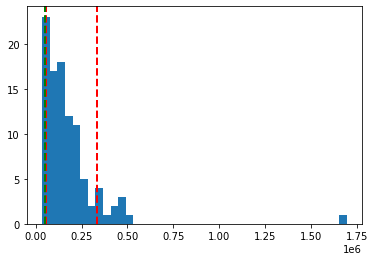

In [120]:
#lastly, we can split the distribution into percentiles
#to help us gauge risk vs. reward

for element in data.columns:
    #Pull top 10% of possible outcomes
    top_ten = np.percentile(closing_prices[element],100-10)

    #Pull bottom 10% of possible outcomes
    bottom_ten = np.percentile(closing_prices[element],10);

    #create histogram again
    plt.hist(closing_prices[element],bins=40)
    #append w/ top 10% line
    plt.axvline(top_ten,color='r',linestyle='dashed',linewidth=2)
    #append w/ bottom 10% line
    plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2)
    #append with current price
    plt.axvline(data[element][-1],color='g', linestyle='dashed',linewidth=2)

    plt.show()

# Historical 60-40 Portfolio

In [140]:
capital = 100000
weightings = {'Bonds':0.4,'S&P500':0.6,'BTC':0.0}

In [141]:
portfolio = data.pct_change() + 1
for element in data.columns:
    portfolio[element][0] = capital*weightings[element]

In [142]:
for loc in list(range(len(portfolio))):
    for element in data.columns:
        if loc != 0:
            portfolio[element][loc] = portfolio[element][loc-1] * portfolio[element][loc]

In [143]:
portfolio

,Bonds,S&P500,BTC
Date,,,
2015-01-02,40000.000000,60000.000000,0.0
2015-01-05,39629.451931,58916.431115,0.0
2015-01-06,39477.681929,58361.503410,0.0
2015-01-07,39723.224698,59088.753882,0.0
2015-01-08,40022.310965,60137.284088,0.0
...,...,...,...
2021-03-01,53634.503962,127908.280890,0.0
2021-03-02,53554.454154,126910.184538,0.0
2021-03-03,53382.036290,125229.169608,0.0


In [144]:
portfolio['Portfolio'] = portfolio['Bonds'] + portfolio['S&P500']

<AxesSubplot:xlabel='Date'>

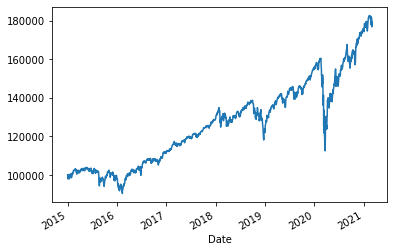

In [145]:
portfolio['Portfolio'].plot()

In [146]:
total_growth = (portfolio['Portfolio'][-1] / portfolio['Portfolio'][1])
cagr = total_growth ** (1/number_of_years) - 1
std_dev = portfolio['Portfolio'].pct_change().std()
std_dev = std_dev * math.sqrt(number_of_trading_days)
print (f"cagr (mean returns) : ", str(round(cagr,4)))
print (f"std_dev (standard deviation of return : ) ", str(round(std_dev,4)))

cagr (mean returns) :  0.1018
std_dev (standard deviation of return : )  0.1436


# Historical 60-30-01 Portfolio

cagr (mean returns) :  0.2184
std_dev (standard deviation of return : )  0.1902


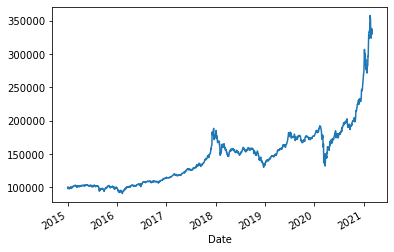

In [147]:
capital = 100000
weightings = {'Bonds':0.39,'S&P500':0.6,'BTC':0.01}
portfolio2 = data.pct_change() + 1
for element in data.columns:
    portfolio2[element][0] = capital*weightings[element]
for loc in list(range(len(portfolio2))):
    for element in data.columns:
        if loc != 0:
            portfolio2[element][loc] = portfolio2[element][loc-1] * portfolio2[element][loc]
portfolio2['Portfolio'] = portfolio2['Bonds'] + portfolio2['S&P500'] + portfolio2['BTC']
portfolio2['Portfolio'].plot()
total_growth = (portfolio2['Portfolio'][-1] / portfolio2['Portfolio'][1])
cagr = total_growth ** (1/number_of_years) - 1
std_dev = portfolio2['Portfolio'].pct_change().std()
std_dev = std_dev * math.sqrt(number_of_trading_days)
print (f"cagr (mean returns) : ", str(round(cagr,4)))
print (f"std_dev (standard deviation of return : ) ", str(round(std_dev,4)))

In [151]:
df = pd.concat([portfolio['Portfolio'],portfolio2['Portfolio']],axis=1)

In [153]:
df.columns = ['60-40-00','60-39-01']

In [155]:
df.to_csv('Portfolio.csv')

# 60-40 w/ Rebalancing

In [196]:
capital = 100000
weightings = {'Bonds':0.4,'S&P500':0.6,'BTC':0.0}

In [197]:
portfolio = data.pct_change() + 1
for element in data.columns:
    portfolio[element][0] = capital*weightings[element]
portfolio['Amount'] = 0
for loc in list(range(len(portfolio))):
    for element in data.columns:
        if loc != 0:
            portfolio[element][loc] = portfolio[element][loc-1] * portfolio[element][loc]
    portfolio['Amount'][loc] = portfolio['Bonds'][loc] + portfolio['S&P500'][loc] + portfolio['BTC'][loc]
    if loc != len(portfolio)-1:
        if portfolio.index[loc+1].year - portfolio.index[loc].year == 1:
            for element in data.columns:
                portfolio[element][loc] = portfolio['Amount'][loc]*weightings[element]


<ipython-input-197-af906a0c4108>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['Amount'][loc] = portfolio['Bonds'][loc] + portfolio['S&P500'][loc] + portfolio['BTC'][loc]
<ipython-input-197-af906a0c4108>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio[element][loc] = portfolio[element][loc-1] * portfolio[element][loc]
<ipython-input-197-af906a0c4108>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio[el

<AxesSubplot:xlabel='Date'>

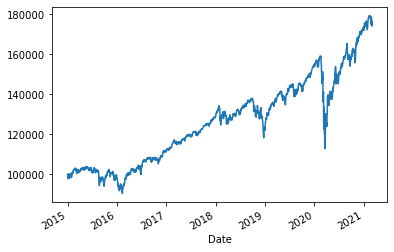

In [207]:
portfolio['Amount'].plot()

In [204]:
total_growth = (portfolio['Amount'][-1] / portfolio['Amount'][1])
cagr = total_growth ** (1/number_of_years) - 1
std_dev = portfolio['Amount'].pct_change().std()
std_dev = std_dev * math.sqrt(number_of_trading_days)
print (f"cagr (mean returns) : ", str(round(cagr,4)))
print (f"std_dev (standard deviation of return : ) ", str(round(std_dev,4)))

cagr (mean returns) :  0.0988
std_dev (standard deviation of return : )  0.1383


# 60-39-01 W/ rebalancing

In [217]:
capital = 100000
weightings = {'Bonds':0.39,'S&P500':0.6,'BTC':0.01}

In [218]:
portfolio2 = data.pct_change() + 1
for element in data.columns:
    portfolio2[element][0] = capital*weightings[element]
portfolio2['Amount'] = 0
for loc in list(range(len(portfolio2))):
    for element in data.columns:
        if loc != 0:
            portfolio2[element][loc] = portfolio2[element][loc-1] * portfolio2[element][loc]
    portfolio2['Amount'][loc] = portfolio2['Bonds'][loc] + portfolio2['S&P500'][loc] + portfolio2['BTC'][loc]
    if loc != len(portfolio2)-1:
        if portfolio2.index[loc+1].year - portfolio2.index[loc].year == 1:
            for element in data.columns:
                portfolio2[element][loc] = portfolio2['Amount'][loc]*weightings[element]

<ipython-input-218-7ac1839bc632>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio2['Amount'][loc] = portfolio2['Bonds'][loc] + portfolio2['S&P500'][loc] + portfolio2['BTC'][loc]
<ipython-input-218-7ac1839bc632>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio2[element][loc] = portfolio2[element][loc-1] * portfolio2[element][loc]
<ipython-input-218-7ac1839bc632>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portf

In [219]:
total_growth = (portfolio2['Amount'][-1] / portfolio2['Amount'][1])
cagr = total_growth ** (1/number_of_years) - 1
std_dev = portfolio2['Amount'].pct_change().std()
std_dev = std_dev * math.sqrt(number_of_trading_days)
print (f"cagr (mean returns) : ", str(round(cagr,4)))
print (f"std_dev (standard deviation of return : ) ", str(round(std_dev,4)))

cagr (mean returns) :  0.1281
std_dev (standard deviation of return : )  0.1408


<AxesSubplot:xlabel='Date'>

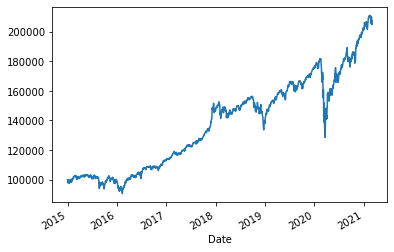

In [220]:
portfolio2['Amount'].plot()

In [222]:
df = pd.concat([portfolio['Amount'],portfolio2['Amount']],axis=1)
df.columns = ['60-40-00','60-39-01']
df.to_csv('Portfolio2.csv')

In [223]:
df

,60-40-00,60-39-01
Date,,
2015-01-02,100000,100000
2015-01-05,98545,98426
2015-01-06,97839,97760
2015-01-07,98811,98753
2015-01-08,100159,100058
...,...,...
2021-03-01,178365,209631
2021-03-02,177413,208436
2021-03-03,175762,206666
